# Monte Carlo Methods 

## `Blackjack-v0`

![alt_text](https://r.hswstatic.com/w_907/gif/how-to-play-blackjack-lead.jpg)

**Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.**

`The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust). 
After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If 
the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided 
by whose sum is closer to 21. 
The reward for winning is +1, drawing is 0, and losing is -1.`
`





`The player can request additional cards (hit). 
The observation of a 3-tuple of: the players current sum, 
the dealer's one showing card (1-10 where 1 is ace), 
and whether or not the player holds a usable ace (0 or 1).
This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto.
http://incompleteideas.net/book/the-book-2nd.html`

In [4]:
import numpy as np
import sys
import gym
from plot_utils import plot_blackjack_values, plot_policy
from collections import defaultdict

env = gym.make('Blackjack-v0')

In [5]:
def generate_episodes_from_limit_stochastic(env):
    episode = []
    observation = env.reset()
    while True:
        probs = [0.8,0.2] if observation[0]<18 else [0.2,0.8]
        action = np.random.choice(np.arange(2),p=probs)
        next_observation, reward, done, info = env.step(action)
        episode.append((observation,action,reward))
        if done:
            break
        observation = next_observation
    return episode

In [42]:
for i in range(3):
    print(generate_episodes_from_limit_stochastic(env))

[((14, 10, True), 1, 0), ((12, 10, False), 0, -1.0)]
[((10, 2, False), 0, 1.0)]
[((14, 6, False), 0, -1.0)]


In [13]:
def mc_prediction_q(env,num_episode,generate_episode,gamma=1):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda:np.zeros(env.action_space.n))
    Q = defaultdict(lambda:np.zeros(env.action_space.n))
    for i_episode in range(1, num_episode+1):
        episode = generate_episodes_from_limit_stochastic(env)
        states, actions, rewards = zip(*episode)
        if i_episode%1000==0:
            print("\rEpisode {}/{}".format(i_episode,num_episode),end="")
            sys.stdout.flush()
        discount = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discount[:-(1+i)])
            N[state][actions[i]] += 1
            Q[state][actions[i]] = returns_sum[state][actions[i]]/N[state][actions[i]]
    return Q

In [18]:
Q = mc_prediction_q(env,100000,generate_episodes_from_limit_stochastic)

Episode 100000/100000

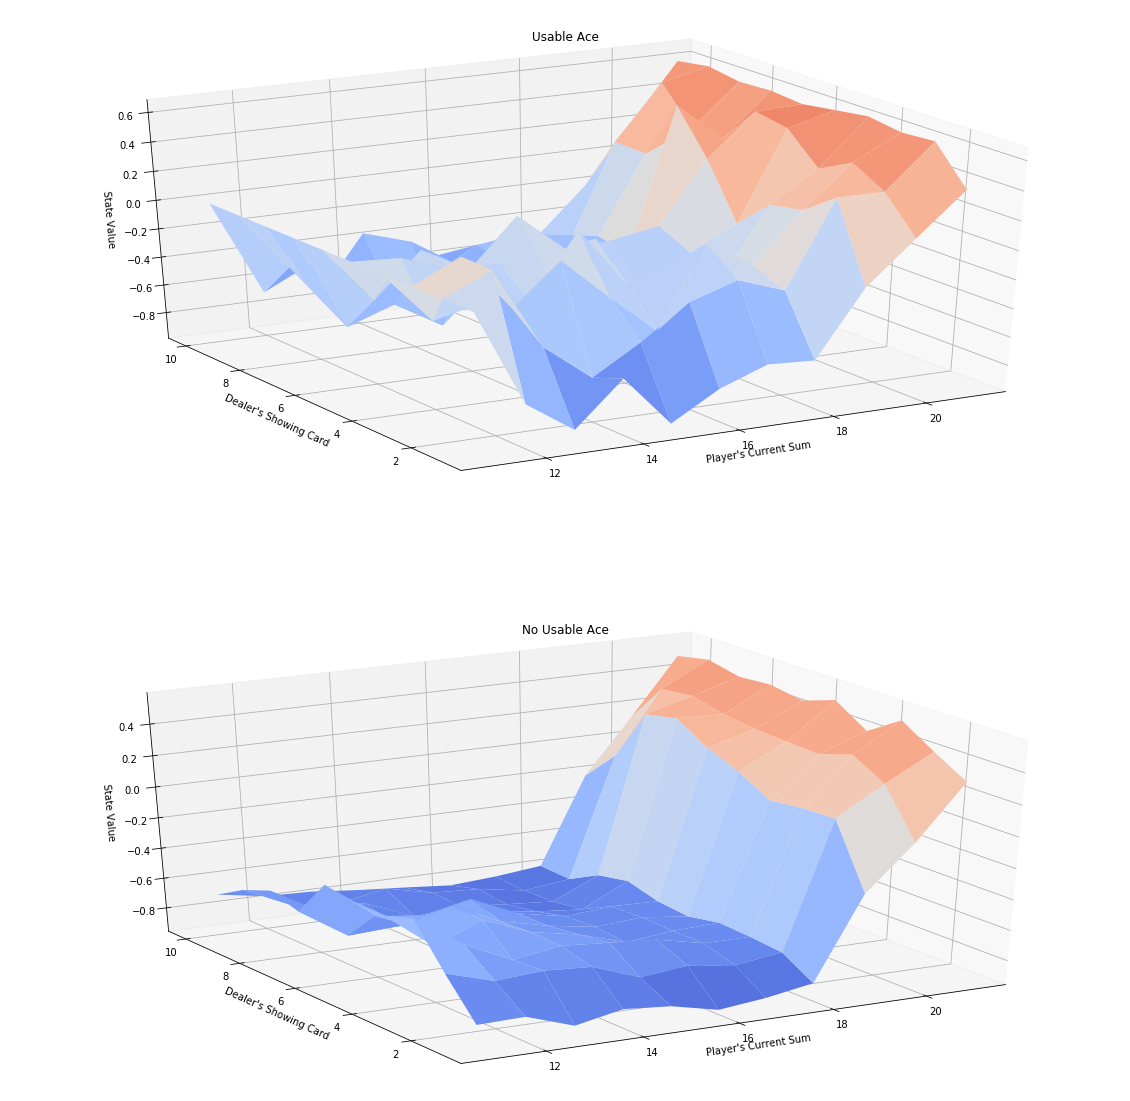

In [19]:
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())
plot_blackjack_values(V_to_plot)

In [39]:
def generate_episode_from_Q(env,Q,epsilon,nA):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [40]:
def get_probs(Q,epsilon,nA):
    p = np.ones(nA) * (epsilon/nA)
    best_a = np.argmax(Q)
    p[best_a] = 1 - epsilon + (epsilon / nA)
    return p

In [50]:
def update_q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discount = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discount[:-(1+i)])-old_Q)
    return Q

In [51]:
def mc_control(env,num_episodes,alpha,gamma=1.0,eps_start=1.0,eps_decay=.9999,eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda:np.zeros(nA))
    epsilon = eps_start
    for i_episode in range(1,num_episodes+1):
        if i_episode%1000==0:
            print("\r Episode {}/{}".format(i_episode,num_episodes),end="")
        epsilon = max(epsilon*eps_decay,eps_min)
        episode = generate_episode_from_Q(env,Q,epsilon,nA)
        Q = update_q(env,episode,Q,alpha,gamma)
    policy = dict((k,np.argmax(v)) for k,v in Q.items())
    return policy, Q        

In [59]:
policy, Q = mc_control(env,5000,0.02)

 Episode 5000/5000

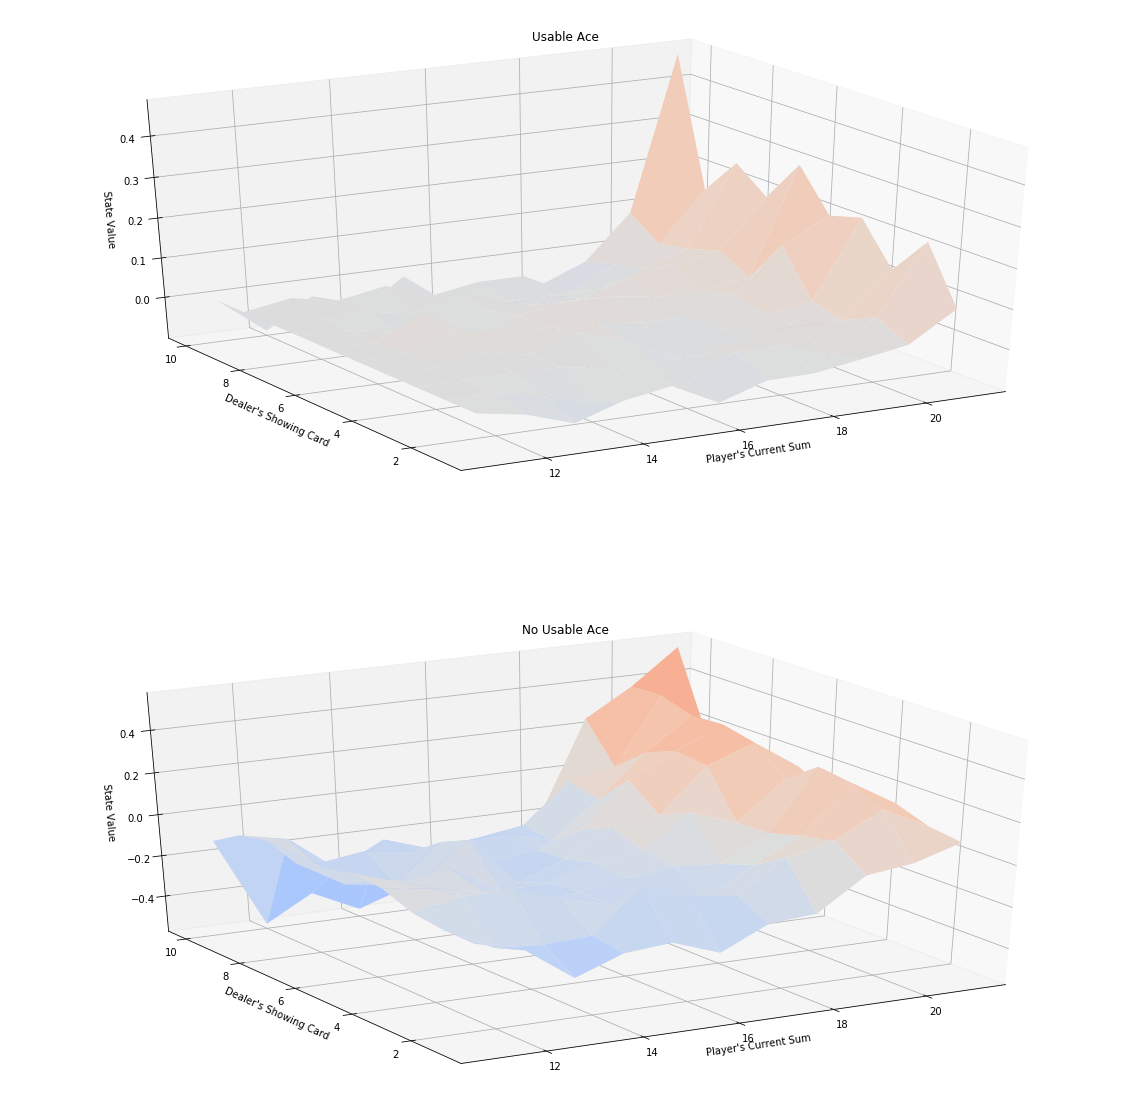

In [60]:
V = dict((k,np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)

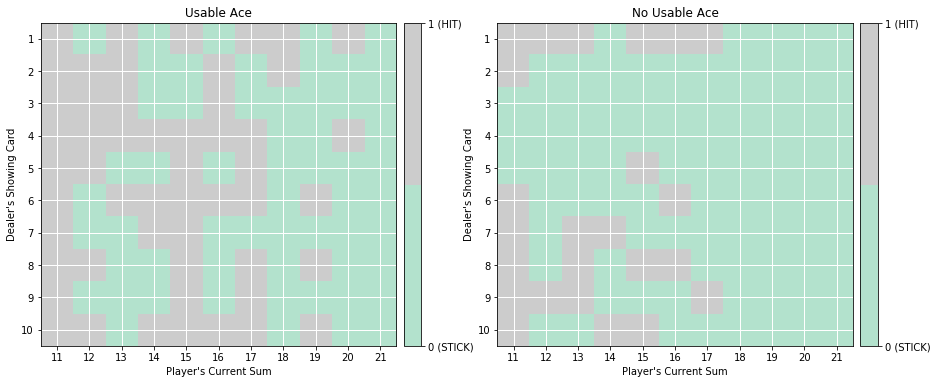

In [61]:
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)